In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  

In [ ]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [3]:
sheet = pd.read_excel('data_input_auto/山东柴油裂解差(拟合残差).xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['山东柴油裂解差'].last_valid_index()

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=30, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()

,山东柴油裂解差拟合残差/中国独立炼厂柴油库存,山东柴油裂解差,中国独立炼厂柴油库存
2025-06-04,NaN,NaN,NaN
2025-06-05,NaN,NaN,NaN
2025-06-06,NaN,NaN,NaN
2025-06-09,NaN,NaN,NaN
2025-06-10,NaN,NaN,NaN


In [4]:
file_path1 = os.path.expanduser("eta/柴油裂解差拟合残差-库存_合并数据.xlsx") 
sheet1 = pd.ExcelFile(file_path1).parse('Sheet1')
sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
sheet1 = sheet1.drop(columns=['真实值'])
sheet1 = sheet1.dropna()
sheet1 = sheet1.sort_values('Date', ascending=True)
sheet1.head()

,Date,预测值
20,2025-04-27,81.2
19,2025-04-28,111.0
18,2025-04-29,68.9
17,2025-04-30,28.4
16,2025-05-01,70.7


In [5]:
file_path2 = os.path.expanduser("eta/柴油独立炼厂库存_合并数据.xlsx") 
sheet2 = pd.ExcelFile(file_path2).parse('Sheet1')
sheet2['Date'] = pd.to_datetime(sheet2['Date'], errors='coerce')
sheet2 = sheet2.drop(columns=['中国独立炼厂柴油库存'])
sheet2 = sheet2.dropna()
sheet2 = sheet2.sort_values('Date', ascending=True)
sheet2.head()

,Date,中国独立炼厂柴油库存_预测
3,2025-05-02,140.84
2,2025-05-09,139.54
1,2025-05-16,148.64
0,2025-05-23,157.44


In [6]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 
sheet_daily = pd.merge(
    sheet_daily,
    sheet1[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['山东柴油裂解差拟合残差/中国独立炼厂柴油库存'] = sheet_daily['山东柴油裂解差拟合残差/中国独立炼厂柴油库存'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

# 合并 sheet2 
sheet_daily = pd.merge(
    sheet_daily,
    sheet2[['Date', '中国独立炼厂柴油库存_预测']],
    on='Date',
    how='left'
)
sheet_daily['中国独立炼厂柴油库存'] = sheet_daily['中国独立炼厂柴油库存'].fillna(sheet_daily['中国独立炼厂柴油库存_预测'])
sheet_daily = sheet_daily.drop(columns=['中国独立炼厂柴油库存_预测'])


# 将 sheet_daily 重新赋值给 sheet
sheet = sheet_daily.copy()
sheet = sheet.set_index('Date')
sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-03-01')]

In [7]:
sheet_daily

,Date,山东柴油裂解差拟合残差/中国独立炼厂柴油库存,山东柴油裂解差,中国独立炼厂柴油库存
2824,2023-03-01,220.0657,859.3525,NaN
2825,2023-03-02,226.1370,865.4238,NaN
2826,2023-03-03,176.3893,810.0611,128.367
2827,2023-03-06,56.4838,690.1556,NaN
2828,2023-03-07,30.3749,664.0467,NaN
...,...,...,...,...
3400,2025-06-04,NaN,NaN,NaN
3401,2025-06-05,NaN,NaN,NaN
3402,2025-06-06,NaN,NaN,NaN
3403,2025-06-09,NaN,NaN,NaN


In [8]:
# 对中国独立炼厂柴油库存进行线性填充
sheet_daily['中国独立炼厂柴油库存'] = sheet_daily['中国独立炼厂柴油库存'].interpolate(method='linear')
sheet_daily['山东柴油裂解差_预测'] = -8.8008 * sheet_daily['中国独立炼厂柴油库存']  + 1763.4078 + sheet_daily['山东柴油裂解差拟合残差/中国独立炼厂柴油库存']
sheet_daily

,Date,山东柴油裂解差拟合残差/中国独立炼厂柴油库存,山东柴油裂解差,中国独立炼厂柴油库存,山东柴油裂解差_预测
2824,2023-03-01,220.0657,859.3525,NaN,NaN
2825,2023-03-02,226.1370,865.4238,NaN,NaN
2826,2023-03-03,176.3893,810.0611,128.3670,810.064806
2827,2023-03-06,56.4838,690.1556,128.0722,692.753782
2828,2023-03-07,30.3749,664.0467,127.7774,669.239358
...,...,...,...,...,...
3400,2025-06-04,NaN,NaN,157.4400,NaN
3401,2025-06-05,NaN,NaN,157.4400,NaN
3402,2025-06-06,NaN,NaN,157.4400,NaN
3403,2025-06-09,NaN,NaN,157.4400,NaN


---

In [9]:
# 创建新的 dataframe merged_df_daily
merged_df_daily = sheet_daily[['Date','山东柴油裂解差', '山东柴油裂解差_预测']].copy()
merged_df_daily.loc[merged_df_daily['Date'] <= last_day, '山东柴油裂解差_预测'] = None
merged_df_daily = merged_df_daily.dropna(subset=['山东柴油裂解差', '山东柴油裂解差_预测'], how='all')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/山东柴油裂解差(拟合残差版本)_合并数据.xlsx', index=False,float_format='%.2f')
merged_df_daily.head()

,Date,山东柴油裂解差,山东柴油裂解差_预测
3392,2025/05/23,NaN,503.709848
3391,2025/05/22,NaN,541.599256
3390,2025/05/21,NaN,554.388664
3389,2025/05/20,NaN,618.378072
3388,2025/05/19,NaN,642.867480


In [10]:
merged_df_monthly = sheet_daily[['Date','山东柴油裂解差', '山东柴油裂解差_预测']].copy()
merged_df_monthly.loc[merged_df_monthly['Date'] <= '2024-10-1', '山东柴油裂解差_预测'] = None
merged_df_monthly['Date'] = pd.to_datetime(merged_df_monthly['Date'])
merged_df_monthly = merged_df_monthly.resample('ME', on='Date').last().reset_index()
merged_df_monthly = merged_df_monthly.dropna(subset=['山东柴油裂解差', '山东柴油裂解差_预测'], how='all')
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_df_monthly.to_excel('eta/山东柴油裂解差(拟合残差版本)_月度数据.xlsx', index=False, float_format='%.2f')
merged_df_monthly.head()

,Date,山东柴油裂解差,山东柴油裂解差_预测
26,2025/05/31,NaN,503.709848
25,2025/04/30,622.7508,554.472819
24,2025/03/31,459.0120,464.328215
23,2025/02/28,660.7536,660.757929
22,2025/01/31,293.8440,164.910556


---

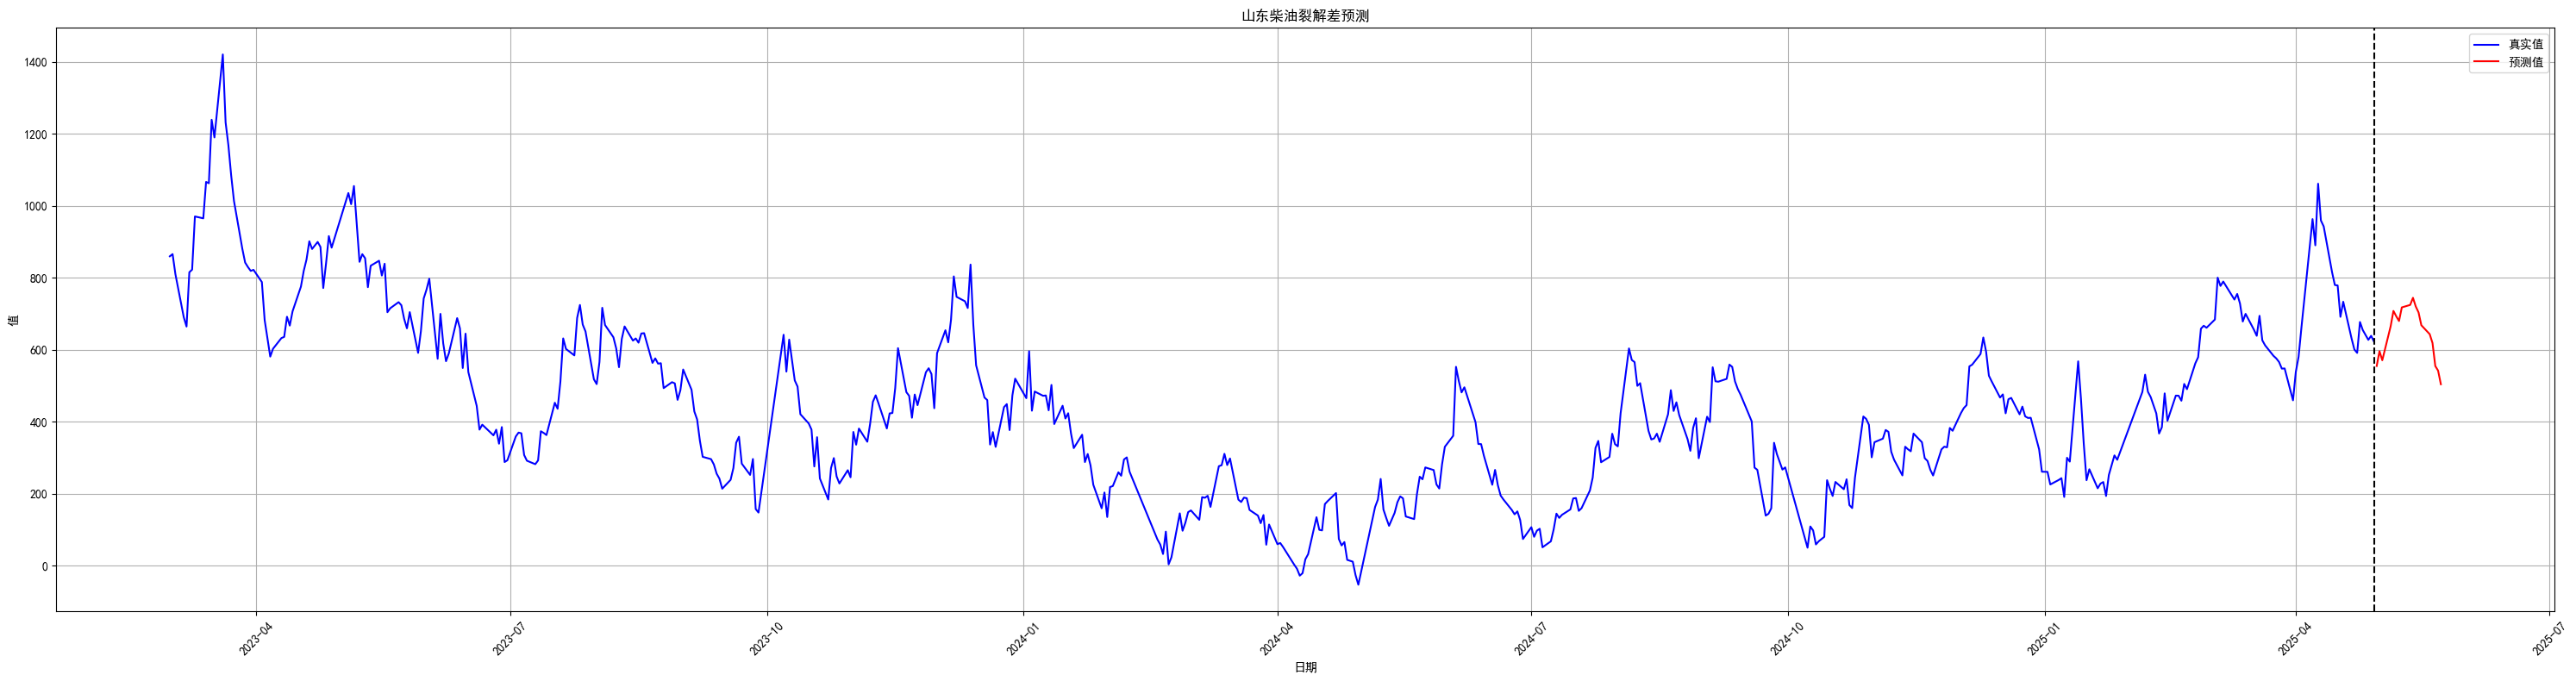

In [11]:
# 设置图形大小
plt.figure(figsize=(30, 8))
merged_df_daily_plot = merged_df_daily
merged_df_daily_plot['Date'] = pd.to_datetime(merged_df_daily_plot['Date'])
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['山东柴油裂解差'], color='blue', label='真实值')
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['山东柴油裂解差_预测'], color='red', label='预测值')
avline_date = pd.to_datetime(last_day)
plt.axvline(x=avline_date, color='black', linestyle='--')
plt.legend()
plt.title('山东柴油裂解差预测')
plt.xlabel('日期')
plt.ylabel('值')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "山东柴油裂解差(拟合残差)"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [13]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "山东柴油裂解差(拟合残差)"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


已完成：插入/更新数据，并重新计算“方向/偏差率” (protected_date = 2025/04/30)
数据已成功更新到Excel文件
